<h1> <center> Tabular Playground Series - Dec 2021</center></h1>


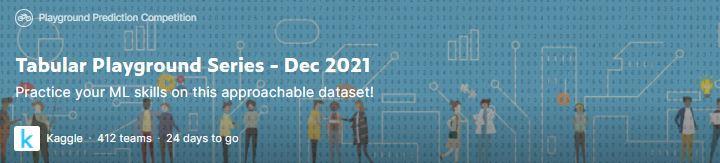

<h2 style='background:#ce67e0; border:0; color:white'><center>Overview</center></h2>

Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, kaggle team have launched many Playground competitions that are more approachable than Featured competitions and thus, more beginner-friendly.

For this competition, you will be predicting a categorical target based on a number of feature columns given in the data. The data is synthetically generated by a GAN that was trained on a the data from [the Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction/overview). This dataset is much larger, and may or may not have the same relationship to the target as the original data.

<h2 style='background:#ce67e0; border:0; color:white'><center>About the data</center></h2>

The dataset as usel consist of three files :

* train.csv - the training data with the target Cover_Type column
* test.csv - the test set; you will be predicting the Cover_Type for each row in this file (the target integer class)
* sample_submission.csv - a sample submission file in the correct format

<h2 style='background:#ce67e0; border:0; color:white'><center>Notebook Set up</center></h2>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)    
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
import random
import os
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  LabelEncoder, RobustScaler , MinMaxScaler ,StandardScaler
import tensorflow as tf 
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.backend as K 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical ,plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer, Flatten 
from tensorflow.random import set_seed
set_seed(42)
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

<h2 style='background:#ce67e0; border:0; color:white'><center>Load Data </center></h2>

In [ ]:
train_data = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test_data= pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
sample = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")
train= train_data.drop('Id', axis=1) # drop unused id 
test= test_data.drop('Id', axis=1)

<h2 style='background:#ce67e0; border:0; color:white'><center> Exploratory data analysis  </center></h2>
As in most compettion and Ml projects we first take a quick look at our train and test data in order to better understand what we are dealing with this month.



#### Train Data 

In [ ]:
train.head(3)

#### Basic summary statistic 

In [ ]:
train.describe().style.background_gradient(cmap='RdPu')

#### Feature variation 

In [ ]:
# variables variaition   
df_var=train.var().reset_index()
df_var.columns =['feature', 'variation']
df_var.sort_values("variation",ascending = False).T

##### Correaltion matrix 

In [ ]:
# Correlation matrix
corrMatrix =train.corr(method='pearson', min_periods=1)
corrMatrix.style.background_gradient(axis=None)

#### Correlation with the target 

In [ ]:
cor_targ = train.corrwith(train["Cover_Type"]).reset_index()
cor_targ.columns =['feature', 'CorrelatioWithTarget']
cor_targ.sort_values('CorrelatioWithTarget',ascending = False).T

Based on feature variation and feature correlation , we can see that some features are more related to target than others and some of them are less variant than others, which gives ideas about feature selection.

### Target Variable
The target for this competition is a multiclass variable (ranging from 1 to 7 )

In [ ]:
ax = plt.figure(figsize=(12, 6))
cover_type= train['Cover_Type'].value_counts().sort_index()
sns.barplot(x=cover_type.index, y=cover_type,palette="BuPu_r")
plt.show()


As we can see , some classes are more represented than others , which make it an imbalanced multi-class classification problem , we should be more carefull when modeling this kind of problem later on we will try to work on that.

### Test Data 
After checking the train data  it's time to check the test data.

In [ ]:
test.head(3)


 #### Basic summary statistics 

In [ ]:
test.describe().style.background_gradient(axis =1)

#### Distribution of Mean and Standard deviation
As in previous tabular playgrounds , we want to see the distribution of the mean and standard deviation values per row and column in both train and test data.

In [ ]:
plt.figure(figsize=(15,8))
features = train.columns.values[0:54]
sns.distplot(train[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="darkblue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per row in the train and test data")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].mean(axis=0),color="orange",kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="blue", kde=True,bins=120, label='test')
plt.title("Distribution of mean values per column in the train and test set")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=1),color="#2F4F4F", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="#FF6347", kde=True,bins=120, label='test')
plt.title("Distribution of std per row in the train and test data ")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=0),color="#778899",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="#800080", kde=True,bins=120, label='test')
plt.title("Distribution of std per column in the train and test data")
plt.legend()
plt.show()

#### Feature Distribution
Now let's check the distribution of numerical features in both train and test data ( binary features don't need visualization )

In [ ]:
num_cols = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
     "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]
i = 1
plt.figure()
fig, ax = plt.subplots(figsize=(18, 15))
for col in num_cols:
    plt.subplot(5,3,i)
    sns.distplot(train[col],color="yellow", kde=True,bins=100, label='train')
    sns.distplot(test[col],color="Darkblue", kde=True,bins=100, label='test')
    i += 1
plt.legend()
plt.title(" numirical features Distribution in both train and test data")  
plt.show()

As we can see the train and test data have similar distribution with slight differences.

<h2 style='background:#ce67e0; border:0; color:white'><center> Implimenting a ResNet baseline </center></h2>


After we did some data exploration , now it's time to train a baseline in order to make prediction , for that we are going to use a residuel network.

#### Data preparation ####

In [ ]:
# remove unuseful features
train = train.drop([ 'Soil_Type7', 'Soil_Type15','Soil_Type1'], axis=1)
test= test.drop(['Soil_Type7', 'Soil_Type15','Soil_Type1'], axis=1)
##### drop class 5 
train =train[train.Cover_Type != 5] 

In [ ]:
y_target = train["Cover_Type"].copy() ##target variable 
X_train = train.copy().drop("Cover_Type",axis = 1) ##train data 

#### check target values again 

In [ ]:
ax = plt.figure(figsize=(12, 6))
cover_type=y_target.value_counts().reset_index()
sns.barplot(x=cover_type.index,data=cover_type,y="Cover_Type",color="salmon")
plt.show()


##### Reduce memory size and clear space

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [ ]:
%%time
X_train = reduce_mem_usage(X_train)
test = reduce_mem_usage(test)

In [ ]:
# i expriment it with skew abd sumù variable but it hurted the performance by -0.0003
#you can expriment with others using the same model or other models 

def stat_features(df):
    #df['f_mean'] = df.mean(axis=1)
    #df['f_std']  = df.std(axis=1)
    df['r_skew'] = df.skew(axis=1)
    df['r_sum'] = df.sum(axis=1)
    return df

#X_train = stat_features(train_df)
#test = stat_features(test_df)

In [ ]:
### delet it 
del train_data 
del test_data 

**Scale data.**

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test= scaler.transform(test)

##### label encoder for target 

In [ ]:
### label encoder for target 
label_encod = LabelEncoder()
y_encoded =label_encod.fit_transform(y_target)
# categorical transofrm for target
#y_cat =to_categorical(y_encoded)

In [ ]:
print(y_encoded.shape,y_target.shape,X_train.shape,test.shape )

#### Build Model 
The model architecture is inspired by Alexander's [Notebook](https://www.kaggle.com/alexryzhkov/python-keras-nn-residual/notebook) with some changes.If you want to know more about ResNet and why it works check this tow youtube videos [what's resnet](https://www.youtube.com/watch?v=ZILIbUvp5lk) and [Why resnet work](https://www.youtube.com/watch?v=RYth6EbBUqM)

In [ ]:
n_classes = 6
def get_model(X_train):
    inputs = layers.Input(shape = (X_train.shape[1],))
    
    hidden = layers.Dense(units=508, kernel_initializer="lecun_normal", activation="selu")(inputs)
    dropout = layers.Dropout(0.3)(hidden)
    hidden1 = tfa.layers.WeightNormalization(layers.Dense(units=256, activation='selu', kernel_initializer="lecun_normal"))(dropout)
    dropout1 = layers.Dropout(0.3)(layers.Concatenate()([hidden1, hidden]))
    hidden2 = tfa.layers.WeightNormalization(layers.Dense(units=128, activation='selu', kernel_initializer="lecun_normal"))(dropout1) 
    dropout2 = layers.Dropout(0.3)(layers.Concatenate()([hidden1,hidden, hidden2]))
    hidden3 = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='selu', kernel_initializer="lecun_normal"))(dropout2) 
    dropout3 = layers.Dropout(0.3)(layers.Concatenate()([hidden3,dropout2, hidden2]))
    hidden4 = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='selu', kernel_initializer="lecun_normal"))(dropout3) 

    # output layer 
    output = layers.Dense(n_classes, activation = 'softmax')(hidden4)
    #model 
    model = keras.Model(inputs=inputs, outputs=output, name="resnet_baseline")
    
    return model


In [ ]:
##model parameters
early_stopping = callbacks.EarlyStopping(patience=10, min_delta=1e-5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor = 0.6, patience = 5, verbose = 0) 
optimizer = keras.optimizers.Adam()
metrics=['acc']
loss= "sparse_categorical_crossentropy"

In [ ]:
model = get_model(X_train)
model.compile(loss=loss, optimizer = optimizer, metrics=metrics)

##### Plot model 

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True
)

**check model summary**

In [ ]:
model.summary()

We got 347,190 params to train , let's go ! 

#### Train and Evaluation 

In [ ]:
epoch = 70
batch_size = 2048
val_score = []
test_pred = np.zeros((1, 1))
N_F = 10  #use 5 folds
SKF= StratifiedKFold(n_splits=N_F, shuffle=True, random_state=42)
for fold, (idx_train, idx_valid) in enumerate(SKF.split(X_train,y_encoded)):
        X_tr, y_tr = X_train[idx_train], y_encoded[idx_train]
        X_val, y_val = X_train[idx_valid], y_encoded[idx_valid]
        K.clear_session()
        model = get_model(X_tr)
        model.compile(loss=loss, optimizer = optimizer, metrics=metrics)
        model.fit(X_tr, y_tr,
              batch_size = batch_size, epochs =epoch,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping, reduce_lr], verbose=0)
        val_pred = np.argmax(model.predict(X_val), axis=1)
        score = accuracy_score(y_val, val_pred)
        val_score.append(score)
        test_pred = test_pred + model.predict(test)
        print(f"FOLD {fold:d}: validation accuracy is {score:.6f}")
        _ = gc.collect()
print ("**************************************************")
print(f"Mean Validation Accuracy is : {np.mean(val_score)}")

##### Convert Prediction

In [ ]:
predictions = np.argmax(test_pred, axis=1)
predictions = label_encod.inverse_transform(predictions)

#### Submission

In [ ]:
sample['Cover_Type'] = predictions 
sample.to_csv('resnet_baseline.csv', index=False)
sample

##### Check predictions distribution 

In [ ]:
ax = plt.figure(figsize=(12, 6))
cover_type=sample['Cover_Type'].value_counts().sort_index(ascending = False )
sns.barplot(x=cover_type.index,y=cover_type,color="salmon")
plt.show()

### How could you improve the score : 
ResNet stand as a strong baseline but if well tuned it can outperform standard DNN,There are many ways that could improve the score including but not limited to :
* Feature engineering and feature selection ( like the ones implimented by [[1]](https://www.kaggle.com/chryzal/features-engineering-for-you) ,[[2]](https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering)) 
* [ Pseudolabeling](https://www.kaggle.com/remekkinas/tps-12-nn-tpu-pseudolabeling-0-95690)
* hyperparameter tuning ( adding more layers , adjusting number of unites and layers connections.. )
* [ensembling NN predictions](https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/)

<h2 style='background:#ce67e0; border:0; color:white'><center>I hope you find this useful , Thank you </center></h2>